# Concurrences

One of the tools in Contact Map Explorer is the ability to look at simultaneous contacts. The idea is that you might have a set of contacts that is likely to happen concurrently, and that this set of contacts might help you define a stable state. This is managed in Contact Map Explorer by what we call contact concurrences.

To start, we'll look at a trajectory of a specific inhibitor during its binding process to GSK3B.

In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from contact_map import ContactFrequency, ResidueContactConcurrence, plot_concurrence
import mdtraj as md
traj = md.load("data/gsk3b_example.h5")
print(traj)  # to see number of frames; size of system

<mdtraj.Trajectory with 100 frames, 5704 atoms, 360 residues, and unitcells>


First, we'll use MDTraj's [atom selection language](http://mdtraj.org/latest/atom_selection.html) to split out the protein and the ligand, which has residue name YYG in the input files. We're only interested in contacts between the protein and the ligand (not contacts within the protein). We'll also only look at heavy atom contacts.

In [2]:
topology = traj.topology
yyg = topology.select('resname YYG and element != "H"')
protein = topology.select('protein and element != "H"')

Now we'll make a list of all the residue contacts that are made, keeping only those that occur more than 20% of the time. We'll put that into a `ResidueContactConcurrence` object, and plot it!

In [3]:
%%time
contacts = ContactFrequency(traj, query=yyg, haystack=protein)

CPU times: user 25.8 s, sys: 37.2 ms, total: 25.8 s
Wall time: 2.51 s


In [4]:
contact_list = [(contact_pair, freq)
                for contact_pair, freq in contacts.residue_contacts.most_common()
                if freq >= 0.2]

In [5]:
%%time
concurrence = ResidueContactConcurrence(traj, contact_list, select="")

CPU times: user 361 ms, sys: 4.04 ms, total: 365 ms
Wall time: 365 ms


In [6]:
# optionally, create x-values... since we know that we have 1 ns/frame
times = [1.0*(i+1) for i in range(len(traj))]

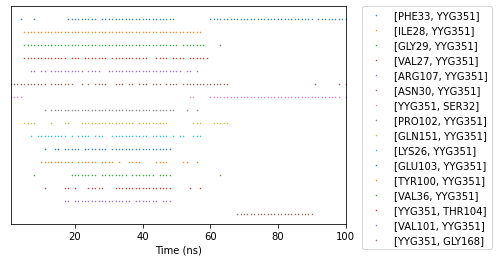

In [7]:
(fig, ax, lgd) = plot_concurrence(concurrence, x_values=times)
plt.xlabel("Time (ns)")
plt.savefig("concurrences.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

This plot shows when each contact occurred. The x-axis is time. Each dot represents that a specific contact pair is present at that time. The contact pairs are separated along the vertical axis, listed in the order from `contact_list` (here, decreasing order of frequency of the contact). The contacts are also listed in that order in the legend, to the right.

This trajectory shows two groups of stable contacts between the protein and the ligand; i.e. there is a change in the stable state. This allows us to visually identify the contacts involved in each state. Both states involve the ligand being in contact with Phe33, but the earlier state includes contacts with Ile28, Gly29, etc., while the later state includes contacts with Ser32 and Gly168.

This change occurs around 60ns (which is also frame 60), and is evident when viewing the MD trajectory. If you have [NGLView](https://github.com/arose/nglview/) installed, visualize the trajectory with the following:

In [8]:
# for visualization, we need to clean up the trajectory:
traj.topology.create_standard_bonds()  # required for image_molecules
traj = traj.image_molecules().superpose(traj)

In [9]:
import nglview as nv
view = nv.show_mdtraj(traj)
view.remove_cartoon()
view.add_cartoon('protein', color='#0000BB', opacity=0.3)
view.add_ball_and_stick("YYG")

# update to my recommeded camera orientation
camera_orientation = [-100,  45, -30, 0,
                        50,  90, -45, 0,
                         0, -45,-100, 0,
                       -50, -45, -45, 1]
view._set_camera_orientation(camera_orientation)

# start trajectory at frame 60: you can scrub forward or backward
view.frame = 60
view

NGLWidget(frame=60, max_frame=99)